<a href="https://colab.research.google.com/github/EnriqueQM/Time_Series/blob/main/Kaggle_Benchmark_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
File_Name = '/content/drive/MyDrive/time_series/time_series/data/ts_kaggle_train.csv'

In [4]:
df = pd.read_csv(File_Name, index_col=0)

In [5]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0
2,2013-01-31,12_11370,16,12,9,11370,699.776786,30.0
3,2013-01-31,12_11373,16,12,9,11373,548.900000,6.0
4,2013-01-31,12_12231,16,12,49,12231,350.000000,3.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1.5+ MB


In [7]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,1222
monthly_sales,728


In [8]:
df.fillna({"monthly_sales":0}, inplace = True)

In [9]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

In [10]:
df.isnull().sum()

,0
date,0
unique_id,0
city_id,0
shop_id,0
item_category_id,0
item_id,0
monthly_average_price,0
monthly_sales,0


In [11]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [12]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

In [13]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0


In [14]:
df['unique_id'].nunique()

426

In [15]:
df['item_id'].nunique()

132

In [16]:
df['shop_id'].nunique()

35

In [17]:
df['shop_id'].value_counts()

,count
shop_id,
31,2618
25,1258
28,986
57,714
42,544
22,544
58,476
19,476
24,476


In [18]:
df['item_category_id'].nunique()

28

In [19]:
df['monthly_sales_lag_1'] = df.groupby('unique_id')['monthly_sales'].shift(1)
df['monthly_sales_lag_2'] = df.groupby('unique_id')['monthly_sales'].shift(2)
df['monthly_sales_lag_3'] = df.groupby('unique_id')['monthly_sales'].shift(3)

In [20]:
df['city_avg_sales'] = df.groupby('city_id')['monthly_sales'].transform('mean')

In [21]:
df.head(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_sales_lag_1,monthly_sales_lag_2,monthly_sales_lag_3,city_avg_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,NaN,NaN,NaN,12.119485
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,30.0,NaN,NaN,12.119485
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,27.0,30.0,NaN,12.119485
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30.0,27.0,30.0,12.119485
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,27.0,30.0,27.0,12.119485


In [22]:
df.shape

(14484, 12)

In [23]:
df["revenue"] = df["monthly_average_price"] * df["monthly_sales"]

In [24]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags):

    assert "date" in df.columns.tolist(), "Date must be in df columns"

    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )

    for lag in range(nr_lags):
        gb_df_[f"{new_name}_lag{lag + 1}"] = gb_df_.groupby(gb_list)[new_name].transform(
            lambda series: series.shift(lag + 1)
        )

    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [25]:
vars_item_id = build_ts_vars(
    df = df,
    gb_list = ["item_id"],
    target_column = "monthly_sales",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3

)

vars_shop_item_revenue = build_ts_vars(
    df = df,
    gb_list = ["shop_id", "item_id"],
    target_column = "revenue",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3

)

Dropping columns that might cause target leakage item_id_monthly_sales_sum
Dropping columns that might cause target leakage shop_id_item_id_revenue_sum


In [26]:
vars_shop_item_revenue

,shop_id,item_id,date,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
0,3,5822,2013-01-31,NaN,NaN,NaN
1,3,5822,2013-02-28,999.0,NaN,NaN
2,3,5822,2013-03-31,999.0,999.0,NaN
3,3,5822,2013-04-30,1049.0,999.0,999.0
4,3,5822,2013-05-31,1048.5,1049.0,999.0
...,...,...,...,...,...,...
14479,59,22088,2015-06-30,357.0,357.0,476.0
14480,59,22088,2015-07-31,476.0,357.0,357.0
14481,59,22088,2015-08-31,833.0,476.0,357.0
14482,59,22088,2015-09-30,833.0,833.0,476.0


In [27]:
print(df.shape)

df = pd.merge(df, vars_item_id, on = ["date", "item_id"], how = "left")
df = pd.merge(df, vars_shop_item_revenue, on = ["date", "shop_id", "item_id"], how = "left")

print(df.shape)

(14484, 13)
(14484, 19)


In [28]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'monthly_sales_lag_1',
 'monthly_sales_lag_2',
 'monthly_sales_lag_3',
 'city_avg_sales',
 'revenue',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'item_id_monthly_sales_sum_lag3',
 'shop_id_item_id_revenue_sum_lag1',
 'shop_id_item_id_revenue_sum_lag2',
 'shop_id_item_id_revenue_sum_lag3']

In [29]:
COLUMNS_TO_DROP = [
    "revenue"
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [30]:
df.set_index("unique_id", inplace = True)

In [31]:
df.shape

(14484, 17)

In [32]:
df.sample(5)

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,monthly_sales_lag_1,monthly_sales_lag_2,monthly_sales_lag_3,city_avg_sales,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
unique_id,,,,,,,,,,,,,,,,,
44_22088,2013-05-31,13,44,83,22088,79.000000,14.0,8.0,5.0,5.0,9.948529,11.0,10.0,5.0,632.0,395.0,395.000000
25_5459,2013-07-31,7,25,55,5459,299.000000,2.0,2.0,1.0,3.0,6.470588,5.0,8.0,4.0,598.0,299.0,897.000000
38_7893,2014-02-28,10,38,6,7893,1856.666667,6.0,6.0,15.0,1.0,4.705882,128.0,202.0,66.0,10541.8,27850.0,1990.000000
42_5820,2015-04-30,14,42,35,5820,3199.000000,5.0,6.0,11.0,30.0,8.156250,31.0,47.0,103.0,19194.0,34859.0,76257.647059
28_16169,2014-01-31,7,28,65,16169,299.000000,17.0,30.0,4.0,13.0,6.470588,120.0,29.0,46.0,8970.0,1196.0,3887.000000


In [32]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [33]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [34]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [35]:
X_train.head(3)

,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales_lag_1,monthly_sales_lag_2,monthly_sales_lag_3,city_avg_sales,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
unique_id,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,NaN,NaN,NaN,12.119485,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,30.0,NaN,NaN,12.119485,30.0,NaN,NaN,45345.378788,NaN,NaN
12_11365,16,12,9,11365,3252.470238,27.0,30.0,NaN,12.119485,27.0,30.0,NaN,41394.375000,45345.378788,NaN


In [36]:
Y_train.head(3)

,monthly_sales
unique_id,
12_11365,30.0
12_11365,27.0
12_11365,30.0


In [37]:
# max_depth
# n_estimators
# early_stopping_rounds

model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True
)

[0]	validation_0-rmse:6.34737	validation_1-rmse:5.86907
[1]	validation_0-rmse:5.38272	validation_1-rmse:4.79687
[2]	validation_0-rmse:4.81467	validation_1-rmse:4.12751
[3]	validation_0-rmse:4.48103	validation_1-rmse:3.71009
[4]	validation_0-rmse:4.28853	validation_1-rmse:3.44308
[5]	validation_0-rmse:4.17210	validation_1-rmse:3.26769
[6]	validation_0-rmse:4.09672	validation_1-rmse:3.19073
[7]	validation_0-rmse:4.03438	validation_1-rmse:3.13500
[8]	validation_0-rmse:3.96462	validation_1-rmse:3.09253
[9]	validation_0-rmse:3.92207	validation_1-rmse:3.06399
[10]	validation_0-rmse:3.89356	validation_1-rmse:3.04784
[11]	validation_0-rmse:3.86503	validation_1-rmse:3.04546
[12]	validation_0-rmse:3.83419	validation_1-rmse:3.07077
[13]	validation_0-rmse:3.80932	validation_1-rmse:3.06277
[14]	validation_0-rmse:3.75726	validation_1-rmse:3.04651
[15]	validation_0-rmse:3.71705	validation_1-rmse:3.04824
[16]	validation_0-rmse:3.68842	validation_1-rmse:3.05093
[17]	validation_0-rmse:3.65859	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

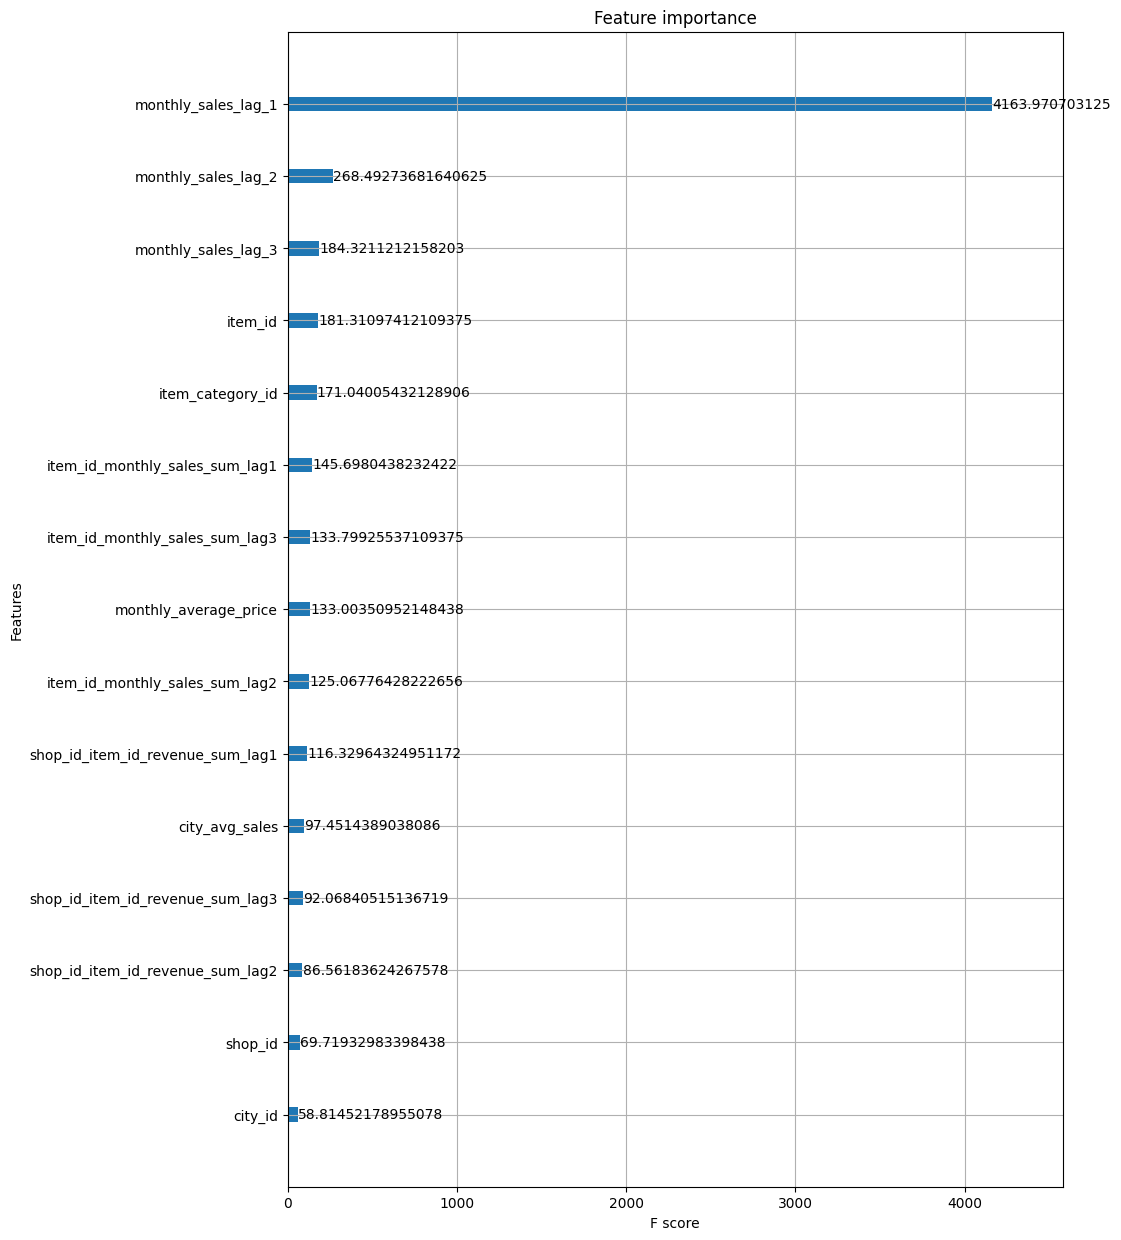

In [38]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [39]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)

Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [40]:
X_test.reset_index(inplace = True)

In [41]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [42]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_747
Validation RMSE: 3_079


In [43]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv(f"submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)